# 01-NBME-Data-Exploration

Background

Objectives

Dataset Overview



In [1]:
# import libraries

import numpy as np
import pandas as pd
import os

In [2]:
df_notes = pd.read_csv('patient_notes.csv')
df_feature = pd.read_csv('features.csv')
df_train = pd.read_csv('train.csv')

In [3]:
df_notes.shape

(42146, 3)

In [4]:
print('unique pn_num:', df_notes['pn_num'].nunique())
print('unique case_num:', df_notes['case_num'].nunique())

unique pn_num: 42146
unique case_num: 10


In [5]:
print('unique records per case:')
df_notes.groupby('case_num')['pn_num'].nunique()

unique records per case:


case_num
0    2268
1     808
2    1958
3    9753
4    5405
5    6909
6    1597
7    4101
8    4196
9    5151
Name: pn_num, dtype: int64

In [6]:
df_train.head()

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


In [7]:
df_train.shape

(14300, 6)

In [9]:
df_notes.head()

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


In [10]:
df_notes.head()

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


In [11]:
df_train_w_notes = pd.merge(df_train, df_notes, how='left', left_on = ['case_num','pn_num'], right_on=['case_num','pn_num'])

df_train_w_notes.shape

(14300, 7)

In [12]:
print('#feature_num: ', df_feature.feature_num.nunique())
print('#feature_txt: ', df_feature.feature_text.nunique()) 

#feature_num:  143
#feature_txt:  131


In [13]:
df_feature[df_feature['feature_text']=='Female']

,feature_num,case_num,feature_text
25,112,1,Female
34,208,2,Female
66,407,4,Female
70,501,5,Female
99,700,7,Female
110,802,8,Female
139,913,9,Female


In [14]:
for col in df_feature.columns:
    print('---------------------------------------','\n')
    print(col, ': ')
    print(df_feature[col].value_counts())
    

--------------------------------------- 

feature_num : 
0      1
611    1
605    1
606    1
607    1
      ..
305    1
306    1
307    1
308    1
916    1
Name: feature_num, Length: 143, dtype: int64
--------------------------------------- 

case_num : 
5    18
8    18
2    17
9    17
3    16
0    13
1    13
6    12
4    10
7     9
Name: case_num, dtype: int64
--------------------------------------- 

feature_text : 
Female                                   7
Male                                     3
20-year                                  2
Nausea                                   2
35-year                                  2
                                        ..
44-year                                  1
Sleep-disturbance-OR-Early-awakenings    1
Heavy-sweating                           1
Onset-3-years-ago                        1
Subjective-fever                         1
Name: feature_text, Length: 131, dtype: int64


In [15]:
df_feature['feature_text'].value_counts()

Female                                   7
Male                                     3
20-year                                  2
Nausea                                   2
35-year                                  2
                                        ..
44-year                                  1
Sleep-disturbance-OR-Early-awakenings    1
Heavy-sweating                           1
Onset-3-years-ago                        1
Subjective-fever                         1
Name: feature_text, Length: 131, dtype: int64

In [16]:
df_feature.groupby(['case_num'])['feature_text'].count()

case_num
0    13
1    13
2    17
3    16
4    10
5    18
6    12
7     9
8    18
9    17
Name: feature_text, dtype: int64

In [17]:
data = pd.merge(df_train_w_notes, df_feature, how='left', left_on = ['case_num','feature_num'], right_on=['case_num','feature_num'])

data.shape

(14300, 8)

In [18]:
data.head()

,id,case_num,pn_num,feature_num,annotation,location,pn_history,feature_text
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],HPI: 17yo M presents with palpitations. Patien...,Family-history-of-MI-OR-Family-history-of-myoc...
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],HPI: 17yo M presents with palpitations. Patien...,Family-history-of-thyroid-disorder
2,00016_002,0,16,2,['chest pressure'],['203 217'],HPI: 17yo M presents with palpitations. Patien...,Chest-pressure
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']",HPI: 17yo M presents with palpitations. Patien...,Intermittent-symptoms
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258'],HPI: 17yo M presents with palpitations. Patien...,Lightheaded


In [46]:
print('unique pn_hisotry records per case in training data:')
data.groupby('case_num')['pn_num'].nunique()

unique pn_hisotry records per case in training data:


case_num
0    100
1    100
2    100
3    100
4    100
5    100
6    100
7    100
8    100
9    100
Name: pn_num, dtype: int64

In [48]:
print('unique # of features per case in training data:')
data.groupby(['case_num'])['feature_num'].nunique()

unique # of features per case in training data:


case_num
0    13
1    13
2    17
3    16
4    10
5    18
6    12
7     9
8    18
9    17
Name: feature_num, dtype: int64

In [64]:
#print('average # of features captured per case in training data:')


case distribution in training data 



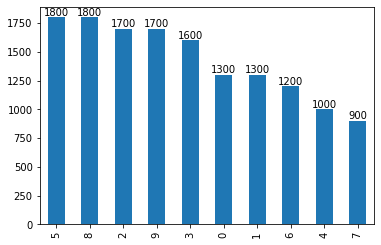

In [36]:
print('case distribution in training data','\n')
ax = data.groupby[['case_num','pn_num']['feature_num'].value_counts().plot(kind='bar')
for container in ax.containers:
    ax.bar_label(container)

In [21]:
print('Feature Entities in Training Data:','\n')
print('#feature_num: ', data.feature_num.nunique())
print('#feature_txt: ', data.feature_text.nunique())    

Feature Entities in Training Data: 

#feature_num:  143
#feature_txt:  131


In [22]:
data['feature_text'].value_counts()

Female                                   700
Male                                     300
20-year                                  200
Nausea                                   200
35-year                                  200
                                        ... 
44-year                                  100
Sleep-disturbance-OR-Early-awakenings    100
Heavy-sweating                           100
Onset-3-years-ago                        100
Subjective-fever                         100
Name: feature_text, Length: 131, dtype: int64

In [23]:
from ast import literal_eval
#mylist = data['location'][0]

In [24]:
data['annot_count'] = data['annotation'].apply(lambda x: len(literal_eval(x)))
data['loc_count'] = data['location'].apply(lambda x: len(literal_eval(x)))

In [25]:
data[['annot_count', 'loc_count']].value_counts()

annot_count  loc_count
1            1            8181
0            0            4399
2            2            1296
3            3             287
4            4              99
5            5              27
6            6               9
7            7               1
8            8               1
dtype: int64

In [26]:
data[data['annot_count']!=data['loc_count']]

,id,case_num,pn_num,feature_num,annotation,location,pn_history,feature_text,annot_count,loc_count


In [85]:
data[data['annot_count']==0].head()

,id,case_num,pn_num,feature_num,annotation,location,pn_history,feature_text,annot_count,loc_count
5,00016_005,0,16,5,[],[],HPI: 17yo M presents with palpitations. Patien...,No-hair-changes-OR-no-nail-changes-OR-no-tempe...,0,0
7,00016_007,0,16,7,[],[],HPI: 17yo M presents with palpitations. Patien...,Shortness-of-breath,0,0
8,00016_008,0,16,8,[],[],HPI: 17yo M presents with palpitations. Patien...,Caffeine-use,0,0
13,00041_000,0,41,0,[],[],17 Y/O M CAME TO THE CLINIC C/O HEART POUNDING...,Family-history-of-MI-OR-Family-history-of-myoc...,0,0
17,00041_004,0,41,4,[],[],17 Y/O M CAME TO THE CLINIC C/O HEART POUNDING...,Lightheaded,0,0


Annotation: 
1. Note that there are 4399 cases where feature_text cannot be found at all in the pn_history; most of time feature_text is represented by continuous texts marked by a single pair of start, end indices, but can also be described by separate texts found throughout pn_history. 
2. Number of annotations for each matches the number of location (start, end) 

In [65]:
#visualize the annotation
#length of the annotation
    

In [91]:
data.to_csv('data.csv', index=False)